In [2]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch.nn.functional as F

from torch_geometric.data import Batch
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset
from rdkit import Chem
from conf_ensemble_dataset import PDBBindConfEnsembleDataset, PlatinumConfEnsembleDataset
from rdkit.Chem import AllChem #needed for rdForceFieldHelpers
from collections import defaultdict
from litschnet import LitSchNet
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from rmsd_predictor_evaluator import RMSDPredictorEvaluator

In [22]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem
from torch_geometric.loader import DataLoader
from rdkit import DataStructs
from sklearn.metrics import r2_score
from tqdm import tqdm
from collections import defaultdict
from torch_geometric.data import Batch

class RMSDPredictorEvaluator() :
    
    def __init__(self, model, show_individual_scatterplot=False) :
        self.model = model
        self.show_individual_scatterplot = show_individual_scatterplot
        self.model.eval()
        if torch.cuda.is_available() :
            self.model.to('cuda')
    
    def evaluate(self, dataset) :
        
        self.evaluate_predictions(dataset)
        
    def evaluate_predictions(self, dataset, training_dataset=None) :
        
        #d_smiles_indices = self.get_dataset_smiles_indices(dataset)
        grouped_data = self.group_dataset_by_pdb_id(dataset)
        
        if training_dataset is not None :
            train_smiles = set([Chem.MolToSmiles(data.mol) for data in train_subset])
            train_mols = [Chem.MolFromSmiles(smiles) for smiles in train_smiles]
            train_fps = [AllChem.GetMorganFingerprint(mol, 3) for mol in train_mols]
            max_sims = []
        
        #df = pd.DataFrame() Maybe TODO : return results as a table
        targets = [] 
        preds = []
        losses = []
        all_bioactive_ranks = []
        bioactive_accuracies = []
        generated_accuracies = []
        ccdc_accuracies = []
        n_heavy_atoms = []
        ef20s_pred = []
        ef20s_ccdc = []
        
        print('Starting evaluation')
        for pdb_id, pdb_id_data_list in tqdm(grouped_data.items()) :
        
            pdb_id_loader = DataLoader(pdb_id_data_list, batch_size=16)
            mol_targets = []
            mol_preds = []
            for batch in pdb_id_loader :
                batch.to(self.model.device)

                pred = self.model(batch)
                mol_preds.extend(pred.detach().cpu().numpy().squeeze(1))

                target = self.model._get_target(batch)
                mol_targets.extend(target.cpu().numpy())
        
            preds.append(mol_preds)
            targets.append(mol_targets)
        
            loss = F.mse_loss(torch.tensor(mol_targets), torch.tensor(mol_preds)).item()
            losses.append(loss)
            
            if self.show_individual_scatterplot :
                plt.scatter(mol_targets, mol_preds)
                plt.title(f'Loss : {loss:.2f}')
                plt.xlabel('RMSD')
                plt.ylabel('Predicted RMSD')
                plt.show()
               
            mol_targets = np.array(mol_targets)
            mol_preds = np.array(mol_preds)
            
            is_bioactive = mol_targets == 0
            
            real_ranks = mol_targets.argsort().argsort()
            pred_ranks = mol_preds.argsort().argsort()
            
            bioactive_real_ranks = real_ranks[is_bioactive]
            bioactive_pred_ranks = pred_ranks[is_bioactive]
            
            accuracy = len(set(bioactive_real_ranks).intersection(set(bioactive_pred_ranks))) / is_bioactive.sum()

            all_bioactive_ranks.extend(bioactive_pred_ranks)
            bioactive_accuracies.append(accuracy)

            mol = pdb_id_data_list[0].mol
            
            if training_dataset is not None :
                max_sim = self.get_max_sim_to_train_dataset(mol, train_fps)
                max_sims.append(max_sim)

            n_heavy_atoms.append(mol.GetNumHeavyAtoms())   
        
            mol_targets_generated = mol_targets[~is_bioactive]
            mol_preds_generated = mol_preds[~is_bioactive]

            generated_real_order = mol_targets_generated.argsort()
            generated_pred_order = mol_preds_generated.argsort()
            generated_real_rank = mol_targets_generated.argsort().argsort()
            if generated_real_rank.shape[0] and generated_pred_order.shape[0] : # apparently there are cases where there is a shape 0 with size 0
                ccdc_accuracies.append(generated_real_rank[0] == 0) # we check that the conformation with the lowest bioactive rmsd is the first one
                generated_accuracies.append(generated_real_order[0] == generated_pred_order[0]) # Is the predicted conf id the one with lowest rmsd
            n_generated = len(mol_targets_generated)
            top10_limit = int(n_generated * 10 / 100)
            top20_limit = int(n_generated * 20 / 100)
            if top10_limit != 0 and top20_limit != 0 :
                actives = generated_real_order[:top10_limit]
                active_rate_in_generated = len(actives) / n_generated

                active_rate_in_top20_predicted = len([i for i in generated_pred_order[:top20_limit] if i in actives]) / top20_limit
                ef20_pred = active_rate_in_top20_predicted / active_rate_in_generated
                ef20s_pred.append(ef20_pred)

                active_rate_in_top20_ccdc = len([i for i in range(top20_limit) if i in actives]) / top20_limit
                ef20_ccdc = active_rate_in_top20_ccdc / active_rate_in_generated
                ef20s_ccdc.append(ef20_ccdc)
        
        mean_loss = np.mean(losses)
        print(f'Mean loss : {mean_loss:.2f}')
        
        flatten_targets =  [item for sublist in targets for item in sublist]
        flatten_preds =  [item for sublist in preds for item in sublist]
        r2 = r2_score(flatten_targets, flatten_preds)
        
#         plt.figure()
#         sns.kdeplot(x=flatten_targets, y=flatten_preds, fill=True)
#         #plt.scatter(flatten_targets, flatten_preds)
#         plt.title(f'R2 : {r2:.2f}')
#         plt.xlabel('RMSD')
#         plt.ylabel('Predicted RMSD')
#         plt.plot([0, 5], [0, 5], c='r')
#         plt.show()
        
        print(f'Bioactive ranking accuracy : {np.mean(bioactive_accuracies)}')
        print(f'Median rank : {np.median(all_bioactive_ranks)}')
        
#         plt.figure()
#         plt.hist(all_bioactive_ranks, bins=49)
#         plt.xlabel('Rank')
#         plt.ylabel('Count')
#         plt.title('Distribution of predicted ranks of bioactive conformations')
#         plt.savefig('Histogram_ranks', dpi=300)
#         plt.show()
        
        if training_dataset is not None :
            plt.scatter(bioactive_accuracies, max_sims)
            plt.xlabel('Ranking accuracy')
            plt.ylabel('Maximum similarity to training set')
            plt.show()

            plt.scatter(x=losses, y=max_sims)
            plt.xlabel('RMSD loss')
            plt.ylabel('Maximum similarity to training set')
            plt.show()
        
#         sns.kdeplot(losses, n_heavy_atoms, fill=True)
#         #plt.scatter(losses, n_heavy_atoms)
#         plt.xlabel('RMSD loss')
#         plt.ylabel('Number of heavy atom')
#         plt.show()
        
        print(f'Generated ranking accuracy : {np.mean(generated_accuracies)}')
        print(f'CCDC ranking accuracy : {np.mean(ccdc_accuracies)}')
        print(f'EF20% prediction : {np.mean(ef20s_pred)}')
        print(f'EF20% CCDC : {np.mean(ef20s_ccdc)}')
        
    def get_max_sim_to_train_dataset(self, mol, train_fps) :
        test_fp = AllChem.GetMorganFingerprint(mol, 3)
        sims = []
        for train_fp in train_fps :
            dice_sim = DataStructs.TanimotoSimilarity(test_fp, train_fp)
            sims.append(dice_sim)
        max_sim = max(sims)
        return max_sim
    
    def get_dataset_smiles_indices(self, dataset) :
        d = defaultdict(list)
        for i, data in enumerate(dataset) :
            smiles = Chem.MolToSmiles(data.mol)
            d[smiles].append(i)
        return d
    
    def group_dataset_by_pdb_id(self, dataset) :
        print('Grouping data by pdb_id')
        d = defaultdict(list)
        for data in dataset :
            pdb_id = data.mol.GetConformer().GetProp('PDB_ID')
            d[pdb_id].append(data)
        return d

In [4]:
pl.seed_everything(42, workers=True)

Global seed set to 42


42

# Data preparation

In [5]:
data_dir = 'data/'

In [6]:
dataset = PDBBindConfEnsembleDataset(data_dir)

Creating molecule encoders


100%|█████████████████████████████████████████████| 8/8 [00:19<00:00,  2.45s/it]


In [7]:
platinum_dataset = PlatinumConfEnsembleDataset(root=data_dir)

Creating molecule encoders


100%|█████████████████████████████████████████████| 8/8 [00:06<00:00,  1.26it/s]


In [8]:
sdsupplier = Chem.rdmolfiles.SDMolSupplier(os.path.join(data_dir, 'platinum-dataset-2017-01-sdf', 'platinum_dataset_2017_01.sdf'))
platinum_mols = [mol for mol in sdsupplier]

In [9]:
platinum_smiles = [Chem.MolToSmiles(mol) for mol in platinum_mols]

In [10]:
dataset_smiles = [Chem.MolToSmiles(data.mol) for data in dataset]

In [11]:
print(len(set(dataset_smiles)))

5996


Grouping data by pdb_id


  1%|▌                                          | 9/674 [00:00<00:08, 79.19it/s]

Starting evaluation


100%|█████████████████████████████████████████| 674/674 [00:06<00:00, 97.01it/s]


Mean loss : 0.42


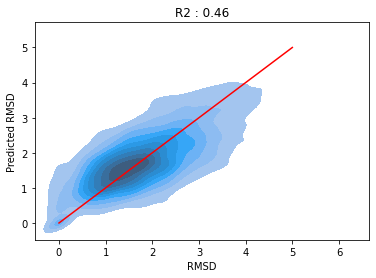

Bioactive ranking accuracy : 0.7759643916913946
Median rank : 0.0


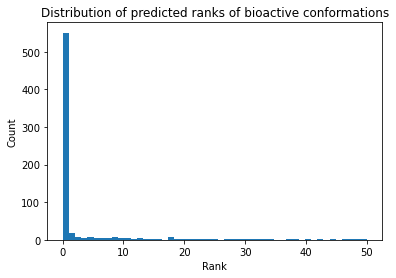

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


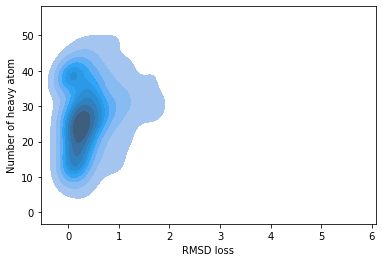

Generated ranking accuracy : 0.1323529411764706
CCDC ranking accuracy : 0.15625
EF20% prediction : 1.578455506929249
EF20% CCDC : 1.2028947848285922
Grouping data by pdb_id


  0%|                                          | 7/4548 [00:00<01:06, 68.65it/s]

Starting evaluation


100%|███████████████████████████████████████| 4548/4548 [00:53<00:00, 84.94it/s]


Mean loss : 0.80


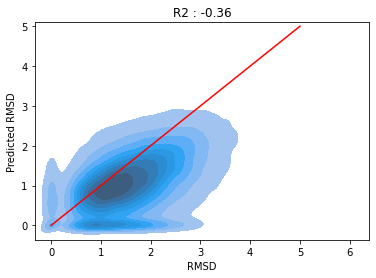

Bioactive ranking accuracy : 0.2590149516270888
Median rank : 5.0


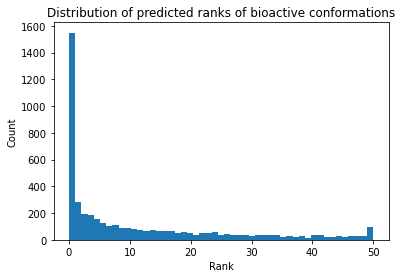

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


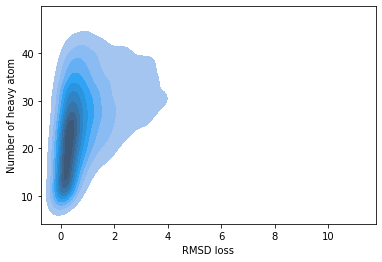

Generated ranking accuracy : 0.1145810424455685
CCDC ranking accuracy : 0.13987244336925445
EF20% prediction : 1.5184196319667438
EF20% CCDC : 1.3706393545830946
Grouping data by pdb_id


  1%|▌                                          | 9/670 [00:00<00:08, 82.10it/s]

Starting evaluation


100%|█████████████████████████████████████████| 670/670 [00:07<00:00, 91.74it/s]


Mean loss : 0.52


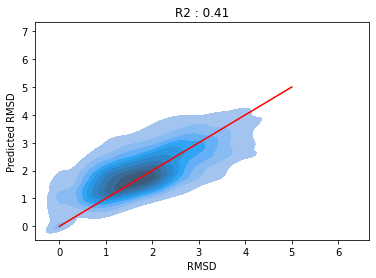

Bioactive ranking accuracy : 0.7611940298507462
Median rank : 0.0


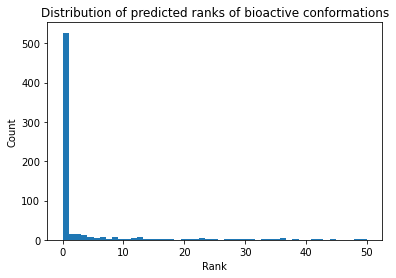

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


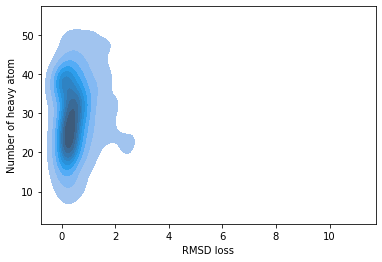

Generated ranking accuracy : 0.12844036697247707
CCDC ranking accuracy : 0.12293577981651377
EF20% prediction : 1.5569915254237288
EF20% CCDC : 1.2649301351896691
Grouping data by pdb_id


  0%|                                          | 7/4548 [00:00<01:11, 63.56it/s]

Starting evaluation


100%|███████████████████████████████████████| 4548/4548 [00:53<00:00, 84.23it/s]


Mean loss : 0.68


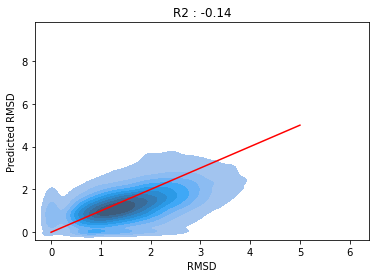

Bioactive ranking accuracy : 0.2609938434476693
Median rank : 4.0


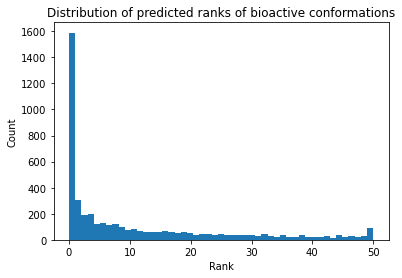

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


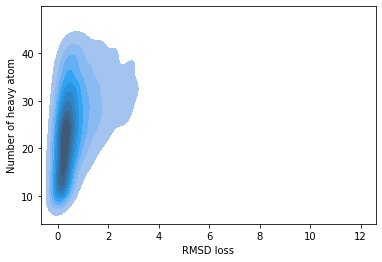

Generated ranking accuracy : 0.11238179019133494
CCDC ranking accuracy : 0.13987244336925445
EF20% prediction : 1.465493874409844
EF20% CCDC : 1.3706393545830946


  0%|                                                   | 0/629 [00:00<?, ?it/s]

Grouping data by pdb_id
Starting evaluation


100%|█████████████████████████████████████████| 629/629 [00:06<00:00, 98.03it/s]


Mean loss : 0.45


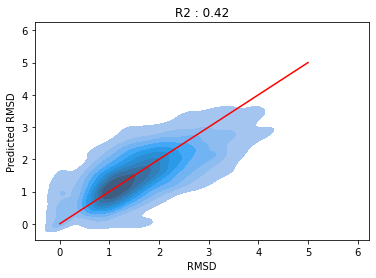

Bioactive ranking accuracy : 0.7503974562798092
Median rank : 0.0


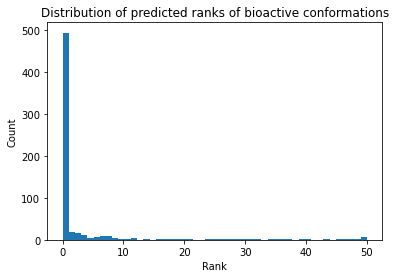

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


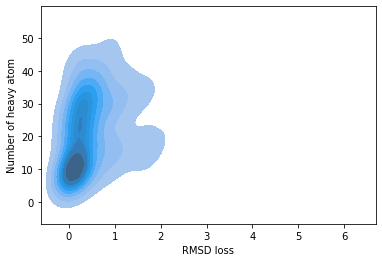

Generated ranking accuracy : 0.10062893081761007
CCDC ranking accuracy : 0.11530398322851153
EF20% prediction : 1.4456273800098027
EF20% CCDC : 1.2675574030087093
Grouping data by pdb_id


  0%|                                          | 7/4548 [00:00<01:08, 66.61it/s]

Starting evaluation


100%|███████████████████████████████████████| 4548/4548 [00:54<00:00, 83.08it/s]


Mean loss : 0.83


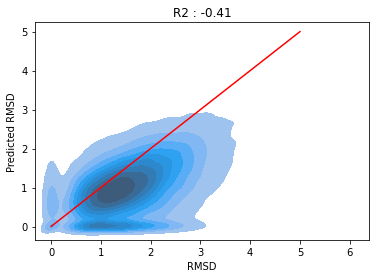

Bioactive ranking accuracy : 0.26517150395778366
Median rank : 4.0


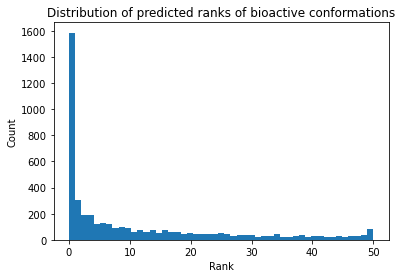

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


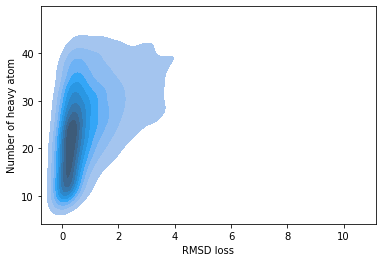

Generated ranking accuracy : 0.1141411919947218
CCDC ranking accuracy : 0.13987244336925445
EF20% prediction : 1.489607733013052
EF20% CCDC : 1.3706393545830946
Grouping data by pdb_id


  2%|▋                                          | 9/553 [00:00<00:06, 87.21it/s]

Starting evaluation


100%|█████████████████████████████████████████| 553/553 [00:06<00:00, 79.89it/s]


Mean loss : 0.61


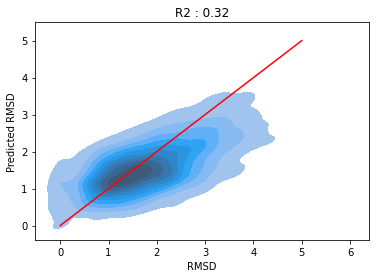

Bioactive ranking accuracy : 0.6799276672694394
Median rank : 0.0


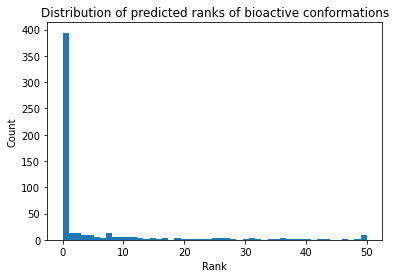

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


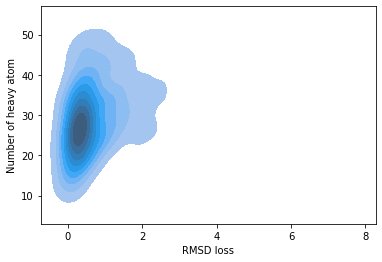

Generated ranking accuracy : 0.08627450980392157
CCDC ranking accuracy : 0.07647058823529412
EF20% prediction : 1.3942775974025974
EF20% CCDC : 1.2092931869717585
Grouping data by pdb_id


  0%|                                          | 7/4548 [00:00<01:09, 65.57it/s]

Starting evaluation


100%|███████████████████████████████████████| 4548/4548 [00:53<00:00, 84.66it/s]


Mean loss : 0.68


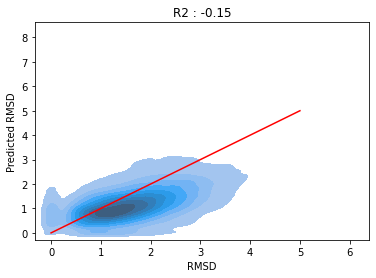

Bioactive ranking accuracy : 0.224934036939314
Median rank : 7.0


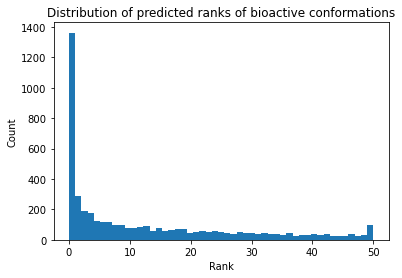

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


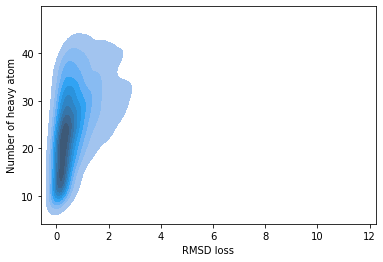

Generated ranking accuracy : 0.10490433252694084
CCDC ranking accuracy : 0.13987244336925445
EF20% prediction : 1.3397131365178934
EF20% CCDC : 1.3706393545830946
Grouping data by pdb_id


  1%|▍                                          | 7/675 [00:00<00:10, 66.02it/s]

Starting evaluation


100%|█████████████████████████████████████████| 675/675 [00:07<00:00, 92.01it/s]


Mean loss : 0.50


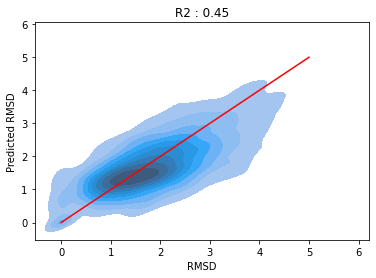

Bioactive ranking accuracy : 0.7792592592592592
Median rank : 0.0


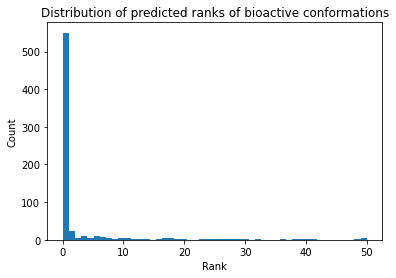

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


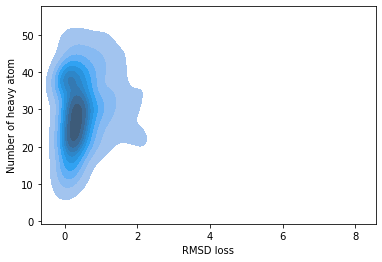

Generated ranking accuracy : 0.11559633027522936
CCDC ranking accuracy : 0.12660550458715597
EF20% prediction : 1.4721978305785124
EF20% CCDC : 1.1435866374786827
Grouping data by pdb_id


  0%|                                          | 7/4548 [00:00<01:06, 68.32it/s]

Starting evaluation


100%|███████████████████████████████████████| 4548/4548 [00:53<00:00, 84.32it/s]


Mean loss : 0.85


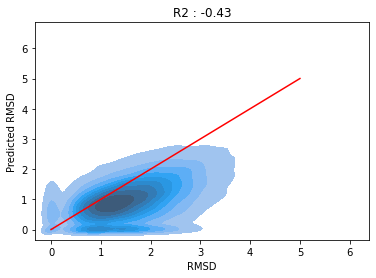

Bioactive ranking accuracy : 0.2515391380826737
Median rank : 5.0


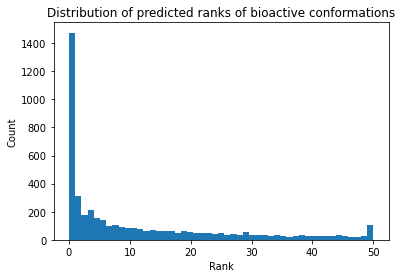

/home/benoit/anaconda3/envs/GeoMol/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


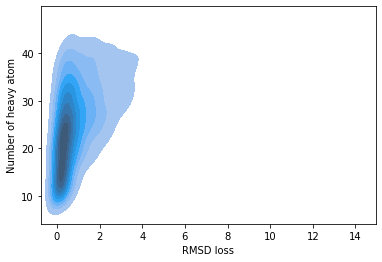

Generated ranking accuracy : 0.11282164064218166
CCDC ranking accuracy : 0.13987244336925445
EF20% prediction : 1.4906571785361644
EF20% CCDC : 1.3706393545830946


In [20]:
for iteration in range(5) :
    with open(os.path.join(data_dir, f'train_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
        train_smiles = f.readlines()
        train_smiles = [smiles.strip() for smiles in train_smiles]
    
    with open(os.path.join(data_dir, f'val_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
        valid_smiles = f.readlines()
        valid_smiles = [smiles.strip() for smiles in valid_smiles]

    with open(os.path.join(data_dir, f'test_smiles_scaffold_split_{iteration}.txt'), 'r') as f :
        test_smiles = f.readlines()
        test_smiles = [smiles.strip() for smiles in test_smiles]
        
    train_indices = [i 
                     for i, data in enumerate(dataset) 
                     if dataset_smiles[i] in train_smiles 
                     and dataset_smiles[i] not in platinum_smiles]

    val_indices = [i 
                   for i, data in enumerate(dataset) 
                   if dataset_smiles[i] in valid_smiles 
                   and dataset_smiles[i] not in platinum_smiles]

    test_indices = [i 
                    for i, data in enumerate(dataset) 
                    if dataset_smiles[i] in test_smiles 
                    and dataset_smiles[i] not in platinum_smiles]
    
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=4)
    
    experiment_name = f'scaffold_split_{iteration}'
    if experiment_name in os.listdir('lightning_logs') :
        checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
        checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
        litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    else :
        litschnet = LitSchNet()
        logger = TensorBoardLogger(save_dir=os.getcwd(), version=experiment_name, name="lightning_logs")
        trainer = pl.Trainer(logger=logger, callbacks=[EarlyStopping(monitor="val_loss", patience=5)], gpus=1)
        trainer.fit(litschnet, train_loader, val_loader)
        trainer.test(litschnet, test_loader)
    
    evaluator = RMSDPredictorEvaluator(model=litschnet)
    evaluator.evaluate(test_subset)
    evaluator.evaluate(platinum_dataset)

In [23]:
for iteration in range(5) :
    with open(os.path.join(data_dir, f'train_smiles_random_split_{iteration}.txt'), 'r') as f :
        train_smiles = f.readlines()
        train_smiles = [smiles.strip() for smiles in train_smiles]
    
    with open(os.path.join(data_dir, f'val_smiles_random_split_{iteration}.txt'), 'r') as f :
        valid_smiles = f.readlines()
        valid_smiles = [smiles.strip() for smiles in valid_smiles]

    with open(os.path.join(data_dir, f'test_smiles_random_split_{iteration}.txt'), 'r') as f :
        test_smiles = f.readlines()
        test_smiles = [smiles.strip() for smiles in test_smiles]
        
    train_indices = [i 
                     for i, data in enumerate(dataset) 
                     if dataset_smiles[i] in train_smiles 
                     and dataset_smiles[i] not in platinum_smiles]

    val_indices = [i 
                   for i, data in enumerate(dataset) 
                   if dataset_smiles[i] in valid_smiles 
                   and dataset_smiles[i] not in platinum_smiles]

    test_indices = [i 
                    for i, data in enumerate(dataset) 
                    if dataset_smiles[i] in test_smiles 
                    and dataset_smiles[i] not in platinum_smiles]
    
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)
    
    train_loader = DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_subset, batch_size=64, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=4)
    
    experiment_name = f'random_split_{iteration}'
    if experiment_name in os.listdir('lightning_logs') :
        checkpoint_name = os.listdir(os.path.join('lightning_logs', experiment_name, 'checkpoints'))[0]
        checkpoint_path = os.path.join('lightning_logs', experiment_name, 'checkpoints', checkpoint_name)
        litschnet = LitSchNet.load_from_checkpoint(checkpoint_path=checkpoint_path)
    else :
        litschnet = LitSchNet()
        logger = TensorBoardLogger(save_dir=os.getcwd(), version=experiment_name, name="lightning_logs")
        trainer = pl.Trainer(logger=logger, callbacks=[EarlyStopping(monitor="val_loss", patience=5)], gpus=1)
        trainer.fit(litschnet, train_loader, val_loader)
        trainer.test(litschnet, test_loader)
    
    evaluator = RMSDPredictorEvaluator(model=litschnet)
    evaluator.evaluate(test_subset)
    evaluator.evaluate(platinum_dataset)

Grouping data by pdb_id


  1%|▎                                         | 8/1043 [00:00<00:14, 71.98it/s]

Starting evaluation


100%|██████████████████████████████████████| 1043/1043 [00:09<00:00, 114.84it/s]


Mean loss : 0.22
Bioactive ranking accuracy : 0.8744007670182167
Median rank : 0.0
Generated ranking accuracy : 0.16225165562913907
CCDC ranking accuracy : 0.13741721854304637
EF20% prediction : 2.1357761935523563
EF20% CCDC : 1.3570749892334195
Grouping data by pdb_id


  0%|                                          | 7/4548 [00:00<01:10, 64.24it/s]

Starting evaluation


100%|███████████████████████████████████████| 4548/4548 [00:53<00:00, 84.32it/s]


Mean loss : 1.13
Bioactive ranking accuracy : 0.2726473175021988
Median rank : 4.0
Generated ranking accuracy : 0.1216186496591159
CCDC ranking accuracy : 0.13987244336925445
EF20% prediction : 1.638447931446494
EF20% CCDC : 1.3706393545830946
Grouping data by pdb_id


  1%|▌                                       | 14/1080 [00:00<00:08, 126.38it/s]

Starting evaluation


100%|██████████████████████████████████████| 1080/1080 [00:09<00:00, 117.78it/s]


Mean loss : 0.37
Bioactive ranking accuracy : 0.8648148148148148
Median rank : 0.0
Generated ranking accuracy : 0.1500789889415482
CCDC ranking accuracy : 0.14533965244865718
EF20% prediction : 1.8430299658804332
EF20% CCDC : 1.2870842604954755
Grouping data by pdb_id


  0%|                                          | 7/4548 [00:00<01:06, 68.38it/s]

Starting evaluation


100%|███████████████████████████████████████| 4548/4548 [00:54<00:00, 83.43it/s]


Mean loss : 0.77
Bioactive ranking accuracy : 0.2717678100263852
Median rank : 5.0
Generated ranking accuracy : 0.11524081812183858
CCDC ranking accuracy : 0.13987244336925445
EF20% prediction : 1.5570655093802637
EF20% CCDC : 1.3706393545830946
Grouping data by pdb_id


  1%|▎                                         | 7/1108 [00:00<00:16, 67.98it/s]

Starting evaluation


100%|██████████████████████████████████████| 1108/1108 [00:09<00:00, 116.61it/s]


Mean loss : 0.26
Bioactive ranking accuracy : 0.8745487364620939
Median rank : 0.0
Generated ranking accuracy : 0.1735668789808917
CCDC ranking accuracy : 0.14331210191082802
EF20% prediction : 1.9316179519071308
EF20% CCDC : 1.26515765665719
Grouping data by pdb_id


  0%|                                          | 6/4548 [00:00<01:17, 58.84it/s]

Starting evaluation


100%|███████████████████████████████████████| 4548/4548 [00:54<00:00, 83.61it/s]


Mean loss : 0.98
Bioactive ranking accuracy : 0.2706684256816183
Median rank : 4.0
Generated ranking accuracy : 0.12755663074554652
CCDC ranking accuracy : 0.13987244336925445
EF20% prediction : 1.6195987250972874
EF20% CCDC : 1.3706393545830946
Grouping data by pdb_id


  1%|▍                                       | 12/1061 [00:00<00:09, 107.99it/s]

Starting evaluation


100%|██████████████████████████████████████| 1061/1061 [00:08<00:00, 118.16it/s]


Mean loss : 0.30
Bioactive ranking accuracy : 0.8727615457115928
Median rank : 0.0
Generated ranking accuracy : 0.12
CCDC ranking accuracy : 0.14166666666666666
EF20% prediction : 1.7517943996664813
EF20% CCDC : 1.3047146176888396
Grouping data by pdb_id


  0%|                                          | 7/4548 [00:00<01:06, 68.23it/s]

Starting evaluation


100%|███████████████████████████████████████| 4548/4548 [00:54<00:00, 82.91it/s]


Mean loss : 0.93
Bioactive ranking accuracy : 0.2763852242744063
Median rank : 4.0
Generated ranking accuracy : 0.10886298658456126
CCDC ranking accuracy : 0.13987244336925445
EF20% prediction : 1.551558156805151
EF20% CCDC : 1.3706393545830946
Grouping data by pdb_id


  1%|▎                                         | 8/1063 [00:00<00:14, 72.04it/s]

Starting evaluation


100%|██████████████████████████████████████| 1063/1063 [00:09<00:00, 114.72it/s]


Mean loss : 0.30
Bioactive ranking accuracy : 0.8438381937911571
Median rank : 0.0
Generated ranking accuracy : 0.159375
CCDC ranking accuracy : 0.1640625
EF20% prediction : 1.8635245780497176
EF20% CCDC : 1.305124922408442
Grouping data by pdb_id


  0%|                                          | 7/4548 [00:00<01:07, 66.85it/s]

Starting evaluation


100%|███████████████████████████████████████| 4548/4548 [00:58<00:00, 78.36it/s]

Mean loss : 0.82
Bioactive ranking accuracy : 0.2640721196130167
Median rank : 5.0
Generated ranking accuracy : 0.12227842533538597
CCDC ranking accuracy : 0.13987244336925445
EF20% prediction : 1.5747962717496826
EF20% CCDC : 1.3706393545830946
